# Clustering Similar Stocks

In this notebook, we attempt to find similar stocks. A technique such as this would be useful for:

- finding stocks that behave similarly (or dissimilarly) to one of interest
- building trading strategies
- identifying anomalies (e.g. if two stocks are normally correlated but fall out of line in a particular day, you might want to investigate)
- discarding bad stocks (if stocks do not correlate with other stocks they might need investigating).


In [1]:
!pip install hdbscan

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import io
import s3fs
import boto3
import sagemaker
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import hdbscan
import time
import seaborn as sns
import collections
%matplotlib inline
mpl.rcParams['figure.figsize'] = (5, 3) # use bigger graphs
interval = "D"
role = sagemaker.get_execution_role()
session = sagemaker.Session()
s3_data_key = 'dbg-stockdata/source'
s3_bucket = 'alphavantage-dcap'

First we load the data resampled at daily interval, from the S3 bucket location that we saved in the data preparation notebook.

In [3]:
%%time

def date_part(dt):
    return str(dt).split(' ')[0]

def load_resampled_from_s3(interval, bucket, s3_data_key):
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/{}/resampled_stockdata.csv".format(s3_data_key, interval))
    loaded = pd.read_csv(io.BytesIO(obj['Body'].read()), index_col=0, parse_dates=True)
    mnemonics = list(loaded.Mnemonic.unique())   
    unique_days = sorted(list(set(map(date_part , list(loaded.index.unique())))))
    return loaded, mnemonics, unique_days

interval = "D"
stockdata, stocksymbols, unique_days = load_resampled_from_s3(interval, s3_bucket, s3_data_key)

CPU times: user 68.4 ms, sys: 19.3 ms, total: 87.7 ms
Wall time: 1.18 s


Also, in order to visualize in the plot with meaningful names for stock symbols, we refer to this list, as provided by Deutsche Borse, that maps the mnemonics to company names.

In [4]:
mnemonic_names = {
     'IBM': 'IBM Common Stock',
    'AAPL' : 'Apple Inc.',
    'MSFT' : 'Microsoft Corporation',
    'AMZN' : 'Amazon.com, Inc.',
    'GOOG' : 'Google ',
    'GOOGL' : 'Alphabet Inc',
    'FB' :'Facebook',
    'MMC':'Marsh & McLennan Companies, Inc.'
}

## Methodology

1. Select a time frame within which to analyze the stocks (e.g. 60 days).
- Select an interval within which to aggregate the prices (e.g. 1 day).
- Select a function of the price such as percent change or log returns.
- Select a similarity function between the timeseries, such as dot product, cosine or correlation coefficient.
- Select a clustering algorithm.
- Visualize the results.

In [5]:
def prepare_single_stock(df, mnemonic, interval):
    single_stock = df[df.Mnemonic == mnemonic].copy()
    single_stock['Avg4Price'] = 0.25*(single_stock['MaxPrice'] + single_stock['MinPrice'] + 
                                      single_stock['StartPrice'] + single_stock['EndPrice'])
    
    resampled = pd.DataFrame({
        'MeanAvg4Price': single_stock['Avg4Price'].resample(interval).mean(),          
        'Mnemonic': mnemonic,
    })
    resampled['PctChange'] = resampled['MeanAvg4Price'].pct_change().fillna(0.0)
    return resampled[['Mnemonic', 'PctChange', 'MeanAvg4Price']]

selected_days = unique_days[0:60]
subset_df = stockdata[stockdata.index.isin(list(selected_days))]
mnemonics = subset_df['Mnemonic'].unique()

In [6]:
single_stocks_dfs = []

interval = 'D'

for mnemonic in mnemonics:
    single_stock = prepare_single_stock(subset_df, mnemonic, interval)
    single_stocks_dfs.append(single_stock)

# the dataframe for clustering    
clustering_df = pd.concat(single_stocks_dfs, axis=0)
clustering_df['CalcDateTime'] = clustering_df.index

In [7]:
cluster_by_feature = 'PctChange' 
subset = clustering_df.pivot(index='CalcDateTime', columns='Mnemonic', values=cluster_by_feature)
corr_mat = subset.corr().fillna(0.0)

In [8]:
def find_most_correlated(corr_mat, mnemonic, n=10):
    results = corr_mat[[mnemonic]].sort_values(mnemonic, ascending=False).head(n).copy()

    results['Desc'] = list(map(lambda m: mnemonic_names[m], list(results.index)))

    results['Corr'] = results[mnemonic]
    
    return results[['Desc', 'Corr']]

find_most_correlated(corr_mat, 'IBM')

Mnemonic,Desc,Corr
Mnemonic,,
IBM,IBM Common Stock,1.000000
GOOG,Google,0.559552
GOOGL,Alphabet Inc,0.554619
AMZN,"Amazon.com, Inc.",0.411187
AAPL,Apple Inc.,0.361615
MSFT,Microsoft Corporation,0.329440
FB,Facebook,0.328590
MMC,"Marsh & McLennan Companies, Inc.",0.111362


In [9]:
class Cluster:
    def __init__(self, cluster_id, members):
        self.cluster_id = cluster_id
        self.members = members
        
    def __repr__(self):
        printstr = "\nCluster {}:".format(self.cluster_id+2)
        for mem in self.members:
            printstr = printstr + "\n\t{}".format(mem)
        return  printstr
        
def build_clusters(data, algorithm, args, kwds, names):
    membership_labels = algorithm(*args, **kwds).fit_predict(data)
    d = collections.defaultdict(list)
    i = 0
    for label in membership_labels:
        d[label].append(names[i])
        i += 1
    clusters = []
    for k,v in d.items():
        clusters.append(Cluster(k, v))
    clusters.sort(key=lambda x: x.cluster_id)

    return membership_labels, clusters


friendly_labels = []

def truncate_str(v):
    t = 12
    if len(v) <= t:
        return v
    return v[0:10] + "..."

for m in list(corr_mat.index):
    friendly_labels.append("{}({})".format(m, mnemonic_names[m]))
   
membership_labels, clusters = build_clusters(corr_mat, hdbscan.HDBSCAN, (), {'min_cluster_size':2}, friendly_labels)
print(clusters)

[
Cluster 1:
	AAPL(Apple Inc.)
	AMZN(Amazon.com, Inc.)
	FB(Facebook)
	GOOG(Google )
	GOOGL(Alphabet Inc)
	IBM(IBM Common Stock)
	MMC(Marsh & McLennan Companies, Inc.)
	MSFT(Microsoft Corporation)]


Although the result of clustering depends on the time period in which the clustering was done, the discretization interval and similarity function chosen, in general you should see somewhat similar stocks clustered together.

For example, automobile companies such as these are cluetered together:

    BMW (BMW)
    Daimler (DAI)
    Porshe (PAH3)
    Continental (CON)
    Volkswagen (VOW3)

Also telecommunication companies are clutered together:

    Nokia (NOA3)
    Vodafone (VODI)
    Telefonica (O2D)
    Deutche Telecom (DTE)

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 8 samples in 0.000s...
[t-SNE] Computed neighbors for 8 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 8 / 8
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.008s
[t-SNE] Iteration 50: error = 44.6394119, gradient norm = 0.2558908 (50 iterations in 0.011s)
[t-SNE] Iteration 100: error = 36.6942749, gradient norm = 0.2026605 (50 iterations in 0.009s)
[t-SNE] Iteration 150: error = 42.1495018, gradient norm = 0.2005733 (50 iterations in 0.009s)
[t-SNE] Iteration 200: error = 47.6219788, gradient norm = 0.4854979 (50 iterations in 0.009s)
[t-SNE] Iteration 250: error = 43.5166702, gradient norm = 0.1466465 (50 iterations in 0.011s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.516670
[t-SNE] Iteration 300: error = 0.2592043, gradient norm = 0.0005619 (50 iterations in 0.009s)
[t-SNE] Iteration 350: error = 0.2033293, gradient norm = 0.000

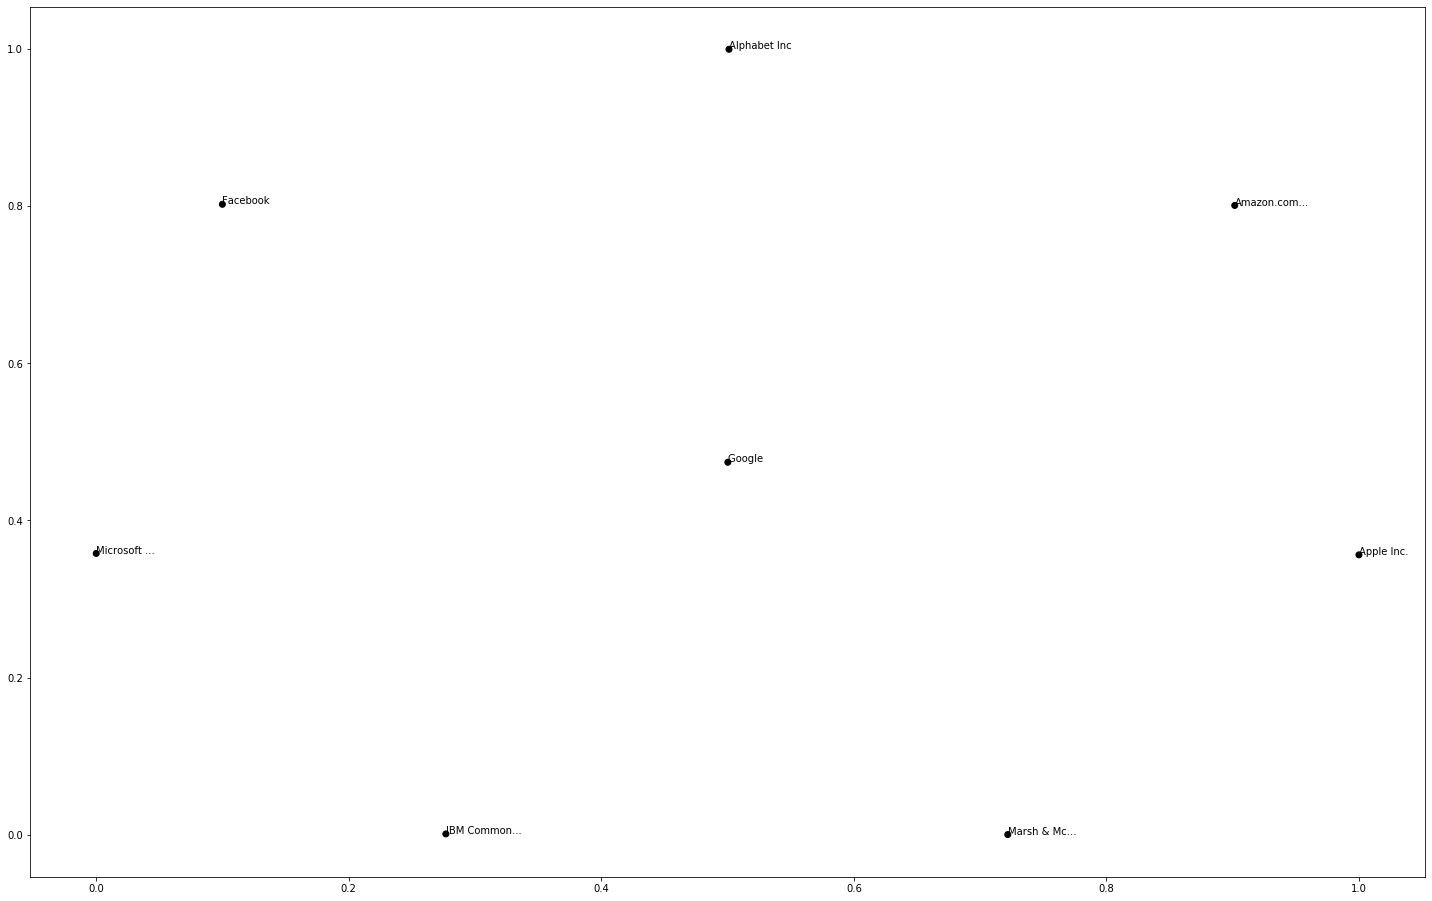

In [10]:
mpl.rcParams['figure.figsize'] = (25, 16) # use bigger graphs

model = TSNE(n_components=2, perplexity=25, verbose=2, random_state=686861).fit_transform(corr_mat)

x_axis=model[:,0]
y_axis=model[:,1]
x_norm = (x_axis-np.min(x_axis)) / (np.max(x_axis) - np.min(x_axis))
y_norm = (y_axis-np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))

fig, ax = plt.subplots()
palette = sns.color_palette('deep', np.unique(membership_labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in membership_labels]
    
ax.scatter(x_norm, y_norm, c = colors)
names = list(corr_mat.index)

for i, name in enumerate(names):
    ax.annotate(truncate_str(mnemonic_names[name]), (x_norm[i],y_norm[i]))    
    
    
fig.savefig('stockclusters.png')

Symbols plotted graphically visually depicts, where you can find some of the prominent clusters, as described above.